In [1]:
# referrence:  https://keras.io/examples/timeseries/timeseries_weather_forecasting/
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import missingno as msno
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']


In [2]:
DATA_DIR = '../../data/data_clean.csv'
raw_df = pd.read_csv(DATA_DIR)
raw_df.columns
raw_df = raw_df.drop(['Source.Name','date','hour','tag'],axis=1)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
/home/zed/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21271 (\N{CJK UNIFIED IDEOGRAPH-5317}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zed/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20140 (\N{CJK UNIFIED IDEOGRAPH-4EAC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zed/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  fig.canvas.print_figure(bytes_io,

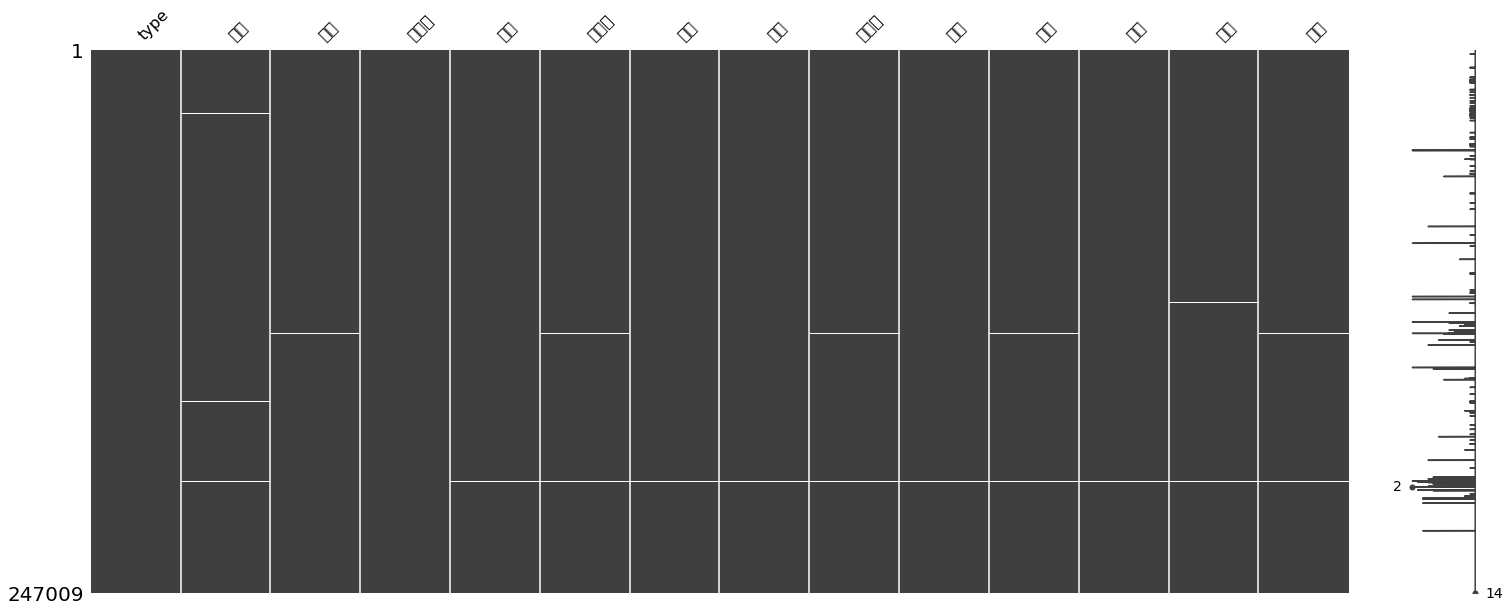

In [3]:
msno.matrix(raw_df);

### 使用O3 日度数据进行预测，将缺失数据剔除

In [4]:
O3 = raw_df[raw_df['type']=='O3_24h'].drop('type',axis=1)
O3['label'] = O3['北京'].shift(-15)
O3 = O3.dropna()

In [5]:
df = O3
df.shape

(60932, 14)

In [6]:
split_fraction = 0.725
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 200
future = 15
learning_rate = 0.00001
batch_size = 256
epochs = 2


In [7]:

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [8]:
features = df.drop(['label'],axis=1)
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [9]:
start = past + future
end = start + train_split

x_train = train_data.values
y_train = features.iloc[start:end][[1]]

sequence_length = 200

In [10]:

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    # sampling_rate=step,
    batch_size=batch_size,
)

2022-05-08 23:32:05.648070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 23:32:05.696573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 23:32:05.696787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 23:32:05.697586: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end,:].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    # sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_val.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 200, 13)
Target shape: (256, 1)


In [12]:
model = keras.Sequential()
model.add(layers.Input(shape=(inputs.shape[1],inputs.shape[2])))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200, 256)          208128    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 257,537
Trainable params: 257,537
Non-trainable params: 0
_________________________________________________________________


In [13]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback,tensorboard_callback],
)

Epoch 1/2


2022-05-08 23:32:09.541980: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


172/172 [==============================] - ETA: 0s - loss: 0.4059
Epoch 1: val_loss improved from inf to 0.23971, saving model to model_checkpoint.h5
172/172 [==============================] - 78s 439ms/step - loss: 0.4059 - val_loss: 0.2397
Epoch 2/2
172/172 [==============================] - ETA: 0s - loss: 0.3192
Epoch 2: val_loss improved from 0.23971 to 0.22740, saving model to model_checkpoint.h5
172/172 [==============================] - 75s 436ms/step - loss: 0.3192 - val_loss: 0.2274


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


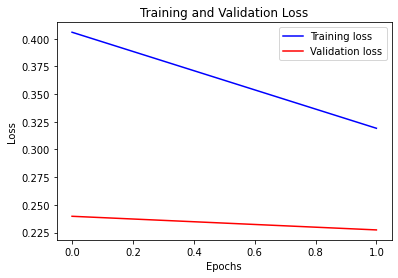

In [14]:

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [15]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return



In [16]:
pred = model.predict(dataset_val)

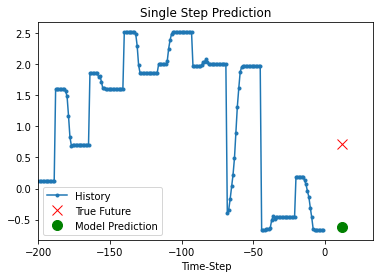

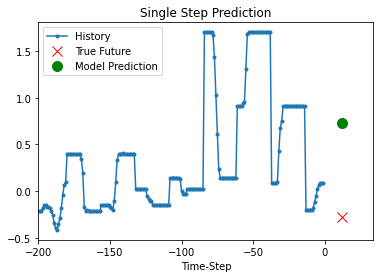

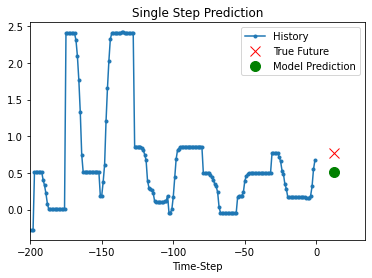

In [17]:

for x, y in dataset_val.take(3):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [18]:
y_val.shape

(16542, 1)

In [19]:
pred = model.predict(dataset_val)

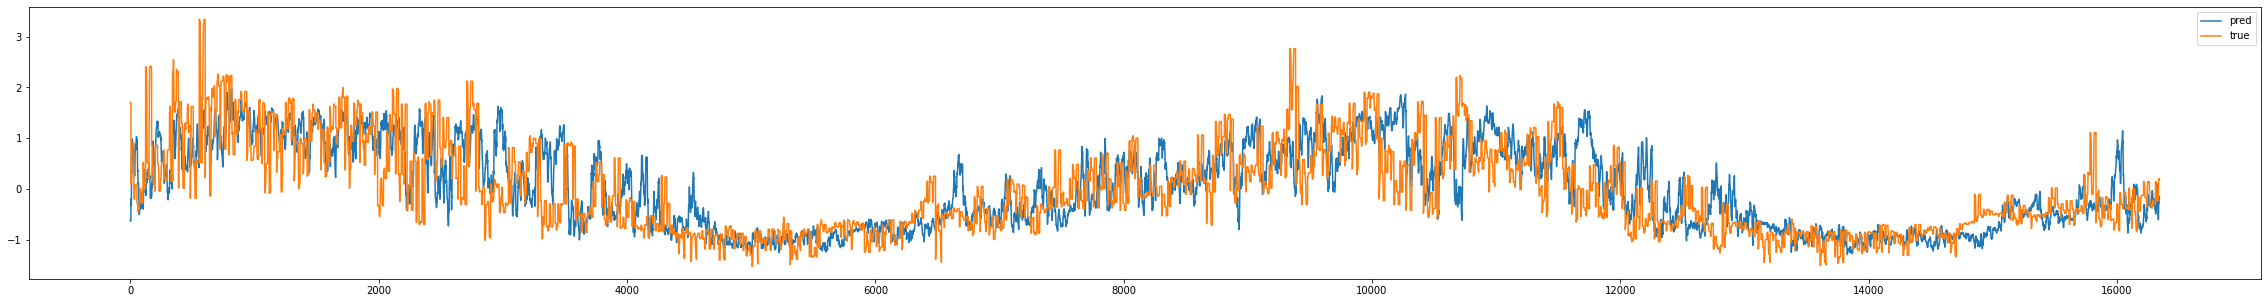

In [20]:
plt.figure(figsize=(40, 5))
plt.plot(pred,label = 'pred')
plt.plot(y_val.values[-len(pred):],label='true')
plt.legend()

In [21]:
y_pred = pred
y_true = y_val.values.flatten()[-len(y_pred):]


In [22]:
from sklearn.metrics import r2_score
r2_score(y_true,y_pred)

0.4799714290126672